In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

data = pd.read_csv(r"[DS Intern] 1_N Model Performance Metrics - 1. Face Match Result.csv")

df = data.copy()

df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Case Num,QC Verdict,Model A,Model B,NaN,NaN,NaN,NaN
2,NaN,1174,MATCH,0.380,0.770,NaN,NaN,Model A,Model B
3,NaN,2515,MATCH,0.440,0.690,NaN,FAR,?,?
4,NaN,250,MATCH,0.250,0.800,NaN,FRR,?,?


FACE MATCH RESULT dataset

In [2]:
# drop kolom yang kamu tidak mau
df = df.drop(columns=["Unnamed: 0", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"])

# hapus baris pertama
df = df.drop(index=0).reset_index(drop=True)

# reset index biar rapi
df = df.reset_index(drop=True)

df.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Case Num,QC Verdict,Model A,Model B
1,1174,MATCH,0.380,0.770
2,2515,MATCH,0.440,0.690
3,250,MATCH,0.250,0.800
4,3923,NOT MATCH,1.000,0.540


In [3]:
# set baris pertama sebagai header
df.columns = df.iloc[0]

# hapus baris pertama (karena sudah jadi header)
df = df.drop(index=0).reset_index(drop=True)

df.head()

,Case Num,QC Verdict,Model A,Model B
0,1174,MATCH,0.380,0.770
1,2515,MATCH,0.440,0.690
2,250,MATCH,0.250,0.800
3,3923,NOT MATCH,1.000,0.540
4,3924,NOT MATCH,1.020,0.610


In [4]:
counts = df['QC Verdict'].value_counts()

print("Jumlah tiap label:")
print(counts)

Jumlah tiap label:
QC Verdict
NOT MATCH    2459
MATCH         509
Name: count, dtype: int64


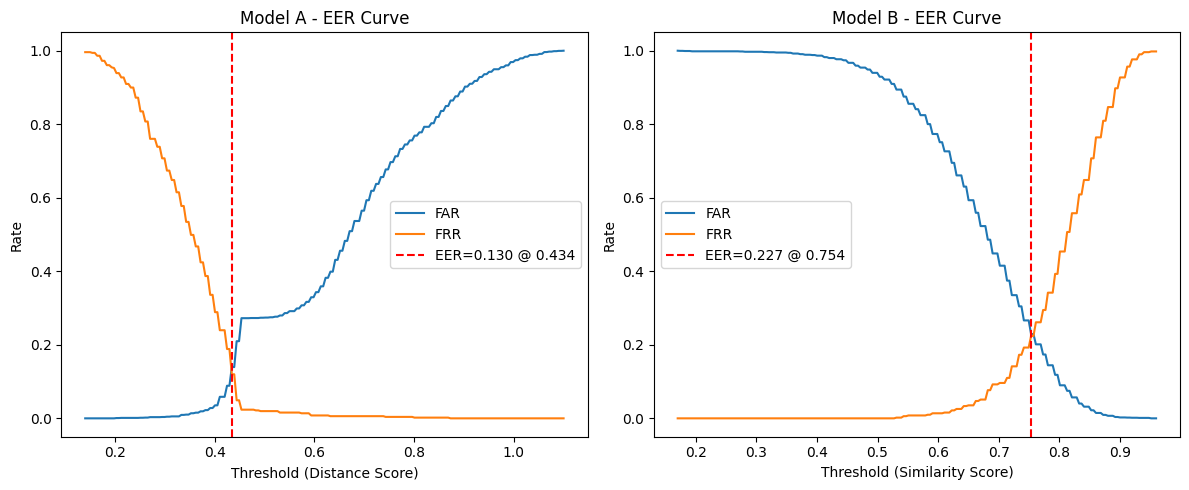

Model A EER: 0.130 pada threshold 0.434
Model B EER: 0.227 pada threshold 0.754


In [ ]:
# Pastikan kolom numerik
df['Model A'] = pd.to_numeric(df['Model A'], errors='coerce')
df['Model B'] = pd.to_numeric(df['Model B'], errors='coerce')

# Label biner: MATCH=1, NOT MATCH=0
labels = df['QC Verdict'].map({'MATCH': 1, 'NOT MATCH': 0}).values

def compute_far_frr(scores, labels, is_distance=True):
    """
    Hitung FAR & FRR untuk berbagai threshold
    - is_distance=True: threshold ke bawah (lebih kecil = MATCH)
    - is_distance=False: threshold ke atas (lebih besar = MATCH)
    """
    thresholds = np.linspace(min(scores), max(scores), 200)
    fars, frrs = [], []

    total_neg = np.sum(labels == 0)  # NOT MATCH
    total_pos = np.sum(labels == 1)  # MATCH

    for th in thresholds:
        if is_distance:
            preds = (scores <= th).astype(int)  # distance kecil = MATCH
        else:
            preds = (scores >= th).astype(int)  # similarity besar = MATCH

        fa = np.sum((preds == 1) & (labels == 0))  # False Accept
        fr = np.sum((preds == 0) & (labels == 1))  # False Reject

        fars.append(fa / total_neg if total_neg > 0 else 0)
        frrs.append(fr / total_pos if total_pos > 0 else 0)

    return thresholds, np.array(fars), np.array(frrs)

# =========================
# Model A (distance score)
thr_a, far_a, frr_a = compute_far_frr(df['Model A'].values, labels, is_distance=True)
eer_idx_a = np.argmin(np.abs(far_a - frr_a))
eer_a = (far_a[eer_idx_a] + frr_a[eer_idx_a]) / 2
eer_thr_a = thr_a[eer_idx_a]

# Model B (similarity score)
thr_b, far_b, frr_b = compute_far_frr(df['Model B'].values, labels, is_distance=False)
eer_idx_b = np.argmin(np.abs(far_b - frr_b))
eer_b = (far_b[eer_idx_b] + frr_b[eer_idx_b]) / 2
eer_thr_b = thr_b[eer_idx_b]

# =========================
# Plot EER curves
plt.figure(figsize=(12,5))

# Model A
plt.subplot(1,2,1)
plt.plot(thr_a, far_a, label='FAR')
plt.plot(thr_a, frr_a, label='FRR')
plt.axvline(eer_thr_a, color='red', linestyle='--', label=f'EER={eer_a:.3f} @ {eer_thr_a:.3f}')
plt.xlabel('Threshold (Distance Score)')
plt.ylabel('Rate')
plt.title('Model A - EER Curve')
plt.legend()

# Model B
plt.subplot(1,2,2)
plt.plot(thr_b, far_b, label='FAR')
plt.plot(thr_b, frr_b, label='FRR')
plt.axvline(eer_thr_b, color='red', linestyle='--', label=f'EER={eer_b:.3f} @ {eer_thr_b:.3f}')
plt.xlabel('Threshold (Similarity Score)')
plt.ylabel('Rate')
plt.title('Model B - EER Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Model A EER: {eer_a:.3f} pada threshold {eer_thr_a:.3f}")
print(f"Model B EER: {eer_b:.3f} pada threshold {eer_thr_b:.3f}")


In [11]:
# Pastikan kolom numerik
df['Model A'] = pd.to_numeric(df['Model A'], errors='coerce')
df['Model B'] = pd.to_numeric(df['Model B'], errors='coerce')

# Label 0 = NOT MATCH, 1 = MATCH
labels = df['QC Verdict'].map({'NOT MATCH':0, 'MATCH':1}).values
# Preprocessing
def preprocess_feature(feature_col):
    X = df[[feature_col]].values
    scaler = StandardScaler()
    return scaler.fit_transform(X)

# Hitung EER
def calculate_eer(y_true, y_pred_prob):
    thresholds = np.linspace(0, 1, 1001)
    fars, frrs = [], []
    total_neg = np.sum(y_true == 0)
    total_pos = np.sum(y_true == 1)

    for th in thresholds:
        y_pred = (y_pred_prob >= th).astype(int)
        fa = np.sum((y_pred == 1) & (y_true == 0))
        fr = np.sum((y_pred == 0) & (y_true == 1))
        FAR = fa / total_neg if total_neg > 0 else 0
        FRR = fr / total_pos if total_pos > 0 else 0
        fars.append(FAR)
        frrs.append(FRR)

    fars, frrs = np.array(fars), np.array(frrs)
    idx_eer = np.argmin(np.abs(fars - frrs))
    eer = (fars[idx_eer] + frrs[idx_eer]) / 2
    return eer

# Training NN sederhana
def train_full_nn(feature_col, labels, fixed_threshold=None, is_distance=False):
    X_scaled = preprocess_feature(feature_col)
    y = labels

    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_scaled.shape[1],),
              kernel_regularizer=regularizers.l2(0.01)),
        Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_scaled, y, epochs=150, batch_size=16, verbose=0)

    # Prediksi probabilitas
    y_pred_prob = model.predict(X_scaled).flatten()

    # Prediksi biner pakai fixed threshold pada raw feature (bukan NN prob)
    if fixed_threshold is not None:
        if is_distance:
            y_pred = (df[feature_col] <= fixed_threshold).astype(int).values
        else:
            y_pred = (df[feature_col] >= fixed_threshold).astype(int).values
    else:
        y_pred = (y_pred_prob >= 0.5).astype(int)

    # Hitung FAR & FRR
    total_neg = np.sum(y == 0)
    total_pos = np.sum(y == 1)
    fa = np.sum((y_pred == 1) & (y == 0))
    fr = np.sum((y_pred == 0) & (y == 1))

    FAR = fa / total_neg if total_neg > 0 else 0
    FRR = fr / total_pos if total_pos > 0 else 0

    return FAR, FRR, fa, fr, total_neg, total_pos, y_pred_prob


# =========================
# Model A (distance score) dengan threshold tetap
FAR_a, FRR_a, fa_a, fr_a, total_neg_a, total_pos_a, y_pred_prob_a = train_full_nn(
    'Model A', labels, fixed_threshold=0.434, is_distance=True
)

# Model B (similarity score) dengan threshold tetap
FAR_b, FRR_b, fa_b, fr_b, total_neg_b, total_pos_b, y_pred_prob_b = train_full_nn(
    'Model B', labels, fixed_threshold=0.754, is_distance=False
)

# Hitung EER
eer_a = calculate_eer(labels, y_pred_prob_a)
eer_b = calculate_eer(labels, y_pred_prob_b)

# =========================
# Print hasil
print("MODEL A:")
print("  False Accepts:", fa_a)
print("  False Rejects:", fr_a)
print("  Total Negatives:", total_neg_a)
print("  Total Positives:", total_pos_a)
print("  FAR:", FAR_a)
print("  FRR:", FRR_a)
print("  EER:", eer_a)

print("\nMODEL B:")
print("  False Accepts:", fa_b)
print("  False Rejects:", fr_b)
print("  Total Negatives:", total_neg_b)
print("  Total Positives:", total_pos_b)
print("  FAR:", FAR_b)
print("  FRR:", FRR_b)
print("  EER:", eer_b)


c:\Users\itn.heydar.alvaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Users\itn.heydar.alvaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MODEL A:
  False Accepts: 343
  False Rejects: 61
  Total Negatives: 2459
  Total Positives: 509
  FAR: 0.13948759658397722
  FRR: 0.11984282907662082
  EER: 0.12966521283029903

MODEL B:
  False Accepts: 564
  False Rejects: 114
  Total Negatives: 2459
  Total Positives: 509
  FAR: 0.2293615290768605
  FRR: 0.22396856581532418
  EER: 0.22666504744609234
